In [1]:
#@title Imports
import math
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

from bisect import bisect_left
from configparser import ConfigParser
from sys import argv

from structure import OBJmatrix
#@title Imports
from sys import argv
import math
import os
from os import listdir
from os.path import isfile, join
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

import numpy as np
from PIL import Image

import tensorflow as tf

In [2]:
#@title Helper methods


class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map

def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [3]:
MODEL_NAME = 'xception_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = MODEL_NAME+'.tar.gz'

model_dir = '../training_model/'

download_path = os.path.join(model_dir, _TARBALL_NAME)

if not isfile(download_path):

    print('downloading model, this might take a while...')
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
    print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

model loaded successfully!


In [ ]:
pictures = !ls '../../Deeplab_sample/'
for pic in pictures:
    jpg = Image.open('../../Deeplab_sample/'+pic)
    resized_im, seg_map = MODEL.run(jpg)
    vis_segmentation(resized_im,seg_map)

In [38]:
jpg = Image.open('../../Deeplab_sample/images (2).jpeg')

In [39]:
resized_im, seg_map = MODEL.run(jpg)

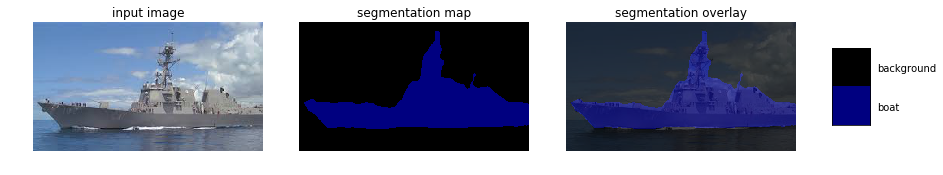

In [40]:
vis_segmentation(resized_im, seg_map)

In [41]:
width = len(seg_map[0])
height = len(seg_map)
difficulty = 80
if width > 100:
    interval = math.ceil(width/difficulty)
if height > 100:
    interval = max(math.ceil(height/difficulty), interval)

In [42]:
mat = []

for index,i in enumerate(seg_map):
    tam = []
    if index % interval == 0:
        for index,j in enumerate(i):
            if index % interval == 0:
                tam.append(1 if j != 0 else 0)
        if tam.count(1)>3:
            mat.append(tam)

for i in range(4 if len(mat)%2 == 0 else 3):
    mat.insert(0,[0 for i in range(len(mat[0]))])
for i in mat:
    for count in range(3):
        i.append(0)
        i.insert(0,0)


In [43]:
if __name__ == "__main__":
    obj = OBJmatrix(matrix=mat,name="selfi.xml",difficulty = difficulty)

In [31]:
def generate_json_levels(matrix,difficulty):
    num_block = 0;
    num_birds = 0;
    length = 1
    height = -1
#     length = 0.24055
#     height = 0.22888
    start_pos = (50,0)
    
    data = {
        "camera": [
            {
                "bottom": 11.281,
                "id": "Slingshot",
                "left": -8.703,
                "right": 67.206,
                "top": -45.651,
                "x": 34.271,
                "y": -17.185
            },
            {
                "bottom": 10.948,
                "id": "Castle",
                "left": 16.106,
                "right": 92.015,
                "top": -45.984,
                "x": 59.08,
                "y": -17.518
            }
        ],
    }
    
    world = {}
    block = matrix
    ftblock = np.fliplr(np.transpose(block))
    for i in range(len(ftblock)):
            for j in range(len(ftblock[i])):
                if ftblock[i][j] != 0 and ftblock[i][j] != 9:
                    addition = (0.5 if j%2==0 else 0)
                    num_block+=1
                    world['block_'+str(num_block)] = {
                            "angle": 0,
                            "x": start_pos[0] +i * length + addition,
                            "y": height * j
                        }
                    if ftblock[i][j] == 32:
                        id = "STONE_BLOCK_2X1"
                    elif ftblock[i][j] == 33:
                        id = "STONE_BLOCK_4X1"
                    elif ftblock[i][j] == 34:
                        id = "STONE_BLOCK_8X1"
                    elif ftblock[i][j] == 35:
                        id = "STONE_BLOCK_10X1"
                    elif ftblock[i][j] == 4:
                        id = "MISC_EXPLOSIVE_TNT"
                    elif ftblock[i][j] == 6:
                        id = "TERRAIN_TEXTURED_HILLS_2X2"
                    elif ftblock[i][j] == 7:
                        id = "PIG_BASIC_SMALL"
                        world['block_'+str(num_block)]['y'] -= 0.015
                    else:
                        id = "ICE_BLOCK_1X1"
                    world['block_'+str(num_block)]['id'] = id
                    world['block_'+str(num_block)]['x'] = round(world['block_'+str(num_block)]['x'],3)
                    world['block_'+str(num_block)]['y'] = round(world['block_'+str(num_block)]['y'],3)
    
    
    #count
    
    if difficulty == 80:
        add_birds(num_birds,"WHITE",1,world)
        num_birds+=1
        add_birds(num_birds,"BLACK",2,world)
        num_birds+=2
        add_birds(num_birds,"RED",2,world)
        num_birds+=2
    elif difficulty == 60:
        count = {
            'birds':4
        }
    else:
        count ={
            'birds':3
        }
    count ={
            'birds':num_birds,
            'blocks':num_block
        }
    
    data['counts'] = count
    data['id'] = 'Testing'
    data['scoreEagle'] = num_block*1000
    data['scoreGold'] = num_block*500
    data['scoreSilver'] = num_block*100
    data['world'] = world
    data['theme'] = 'BACKGROUND_BLUE_GRASS'
    return data

In [120]:
def add_birds(curr_num,name,number,world):
    for i in range(number):
        curr_num+=1
        world['bird_'+str(curr_num)] = {
            "angle": 0,
            "id": "BIRD_"+name,
            "x": 6.068,
            "y": -0.643
        }
    

In [121]:
data = generate_json_levels(obj.matrix,80)

In [122]:
import json

#convert levels to json file
    
with open('../../custom_levels/levels/Level1-2.json', 'w') as outfile:
    json.dump(data, outfile, sort_keys=True, indent=4)
